# Activation Energy Prediction
In this experiment each fuel haas been included as test set and excluded from training set. Each trained model was tried on selected models. Model performances within each trial has been saved as csv file at the end.

File loc: "C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!Exp_data\experiment_results.csv"

Processing fuel type: Cellulose
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 964, number of used features: 23
[LightGBM] [Info] Start training from score 20.901168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

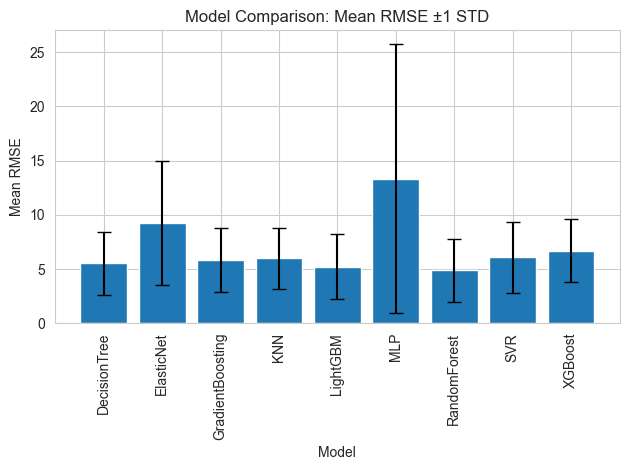

C:\Users\demir\AppData\Local\Temp\ipykernel_18240\3167796210.py:185: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


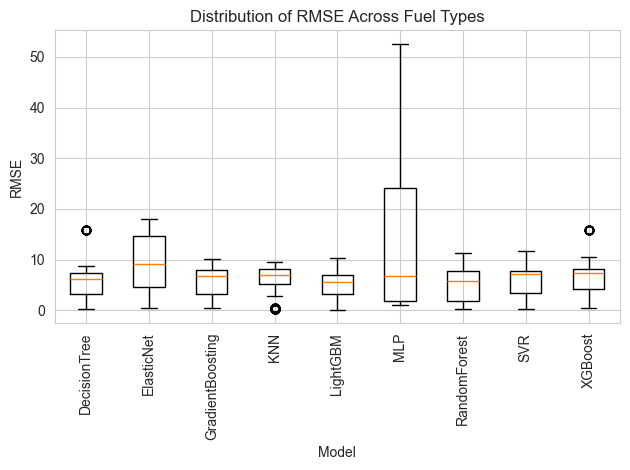

In [119]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load data
data_path = r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\!Data_Ea\mad_t1_Ea.csv"
df = pd.read_csv(data_path, delimiter=',')
df = df[df['fuel_category'] != 'Coal']

# --- Initialize new columns ---
df['second_fuel_category'] = pd.Series(dtype='object')
df['third_fuel_category'] = pd.Series(dtype='object')
df['forth_fuel_category'] = pd.Series(dtype='object')

# --- Rule 1: Lignocellulosic ---
ligno_keywords = ['Hemicellulose', 'Lignin', 'Torr-Wood', 'Wood', 'Cellulose']
mask_ligno = df['fuel_type'].str.contains('|'.join(ligno_keywords), case=False, na=False)
df.loc[mask_ligno, 'second_fuel_category'] = 'Lignocellulosic'
df.loc[mask_ligno, 'third_fuel_category'] = 'Lignocellulosic'
df.loc[mask_ligno, 'forth_fuel_category'] = 'Lignocellulosic'
# --- Rule 2: Anaerobic ---
anaerobic_keywords = ['Digestate', 'Sewage', 'HTC-MSW']
mask_anaerobic = df['fuel_type'].str.contains('|'.join(anaerobic_keywords), case=False, na=False)
df.loc[mask_anaerobic, 'second_fuel_category'] = 'Anaerobic'
df.loc[mask_anaerobic, 'third_fuel_category'] = 'Anaerobic'
df.loc[mask_anaerobic, 'forth_fuel_category'] = 'Anaerobic'
# --- Rule 3: Plastic ---
plastic_keywords = ['RDF1', 'Rubber']
mask_plastic = df['fuel_type'].str.contains('|'.join(plastic_keywords), case=False, na=False)
df.loc[mask_plastic, 'second_fuel_category'] = 'Plastic'
df.loc[mask_plastic, 'third_fuel_category'] = 'Plastic'
df.loc[mask_plastic, 'forth_fuel_category'] = 'Plastic'

rdf_keywords = ['RDF2']
mask_rdf = df['fuel_type'].str.contains('|'.join(rdf_keywords), case=False, na=False)
df.loc[mask_rdf, 'second_fuel_category'] = 'Plastic'
df.loc[mask_rdf, 'third_fuel_category'] = 'Anaerobic'
df.loc[mask_rdf, 'forth_fuel_category'] = 'Lignocellulosic'

# --- Rule 5: Mix → both Plastic and Anaerobic ---
mask_mix = df['fuel_category'] == 'Mix'
df.loc[mask_mix, 'second_fuel_category'] = 'Plastic'
df.loc[mask_mix, 'third_fuel_category'] = 'Anaerobic'
df.loc[mask_mix, 'forth_fuel_category'] = np.nan

# --- Apply One-Hot Encoding to both new columns ---
second_ohe = pd.get_dummies(df['second_fuel_category'], prefix='second_fc' , dummy_na=True)
third_ohe  = pd.get_dummies(df['third_fuel_category'],  prefix='third_fc', dummy_na=True)
forth_ohe  = pd.get_dummies(df['forth_fuel_category'],  prefix='forth_fc', dummy_na=True)
# --- Combine OHE columns with original DataFrame ---
df = pd.concat([df, second_ohe, third_ohe, forth_ohe], axis=1)


fuel_types = df['fuel_type'].unique()
feature_cols = [
      'wc', 'vm', 'fc', 'ac', 'c', 'h', 'o', 'n', 's',
       'cl', 'hc', 'oc', 'lhv', 'temperature', 'residence_time', 'pressure',
       'heat_rate'
]


# These are your original min and max values (as from your summary)
min_values = {
    'wc': 2.6, 'vm': 44.2, 'fc': 3.064326, 'ac': 0.0, 'c': 32.4, 'h': 3.265 , 'lhv': 13.528,
    'o': 7.0, 'n': 0.269662, 's': 0.04642, 'cl': 0.0, 'hc': 0.7, 'oc': 0.0,
    'temperature': 200, 'residence_time': 0.5, 'pressure': 0.5, 'heat_rate': 10,
}
max_values = {
    'wc': 10.8, 'vm': 91.735674, 'fc': 44.5, 'ac': 37.52, 'c': 82.3, 'h': 10.13205, 'lhv': 35.8,
    'o': 54.936839, 'n': 3.9, 's': 2.5, 'cl': 1.5, 'hc': 1.857, 'oc': 1.04402, 'temperature': 1200, 'residence_time': 20, 'pressure': 20, 'heat_rate': 1000
}

# Optional: define a margin (e.g. 10%)
margin_ratio = 0.1

# Create expanded bounds
expanded_bounds = {}
for feat in feature_cols:
    min_val = min_values[feat]
    max_val = max_values[feat]
    range_val = max_val - min_val
    new_min = min_val - range_val * margin_ratio
    if new_min < 0:
        new_min = 0
    new_max = max_val + range_val * margin_ratio
    expanded_bounds[feat] = (round(new_min, 3), round(new_max, 3))

# Prepare fake data to fit the scaler
X_bounds = pd.DataFrame({col: [expanded_bounds[col][0], expanded_bounds[col][1]] for col in feature_cols})

# Fit a global scaler based on the expanded bounds
scaler = MinMaxScaler()
scaler.fit(X_bounds)

# Store results
results = []

# Iterate over each fuel type
for test_fuel in fuel_types:
    print(f"Processing fuel type: {test_fuel}")

    # Train-test split
    train_data = df[df['fuel_type'] != test_fuel].drop(columns=['fuel_type','fuel_category', 'ln_T', 'inv_T', 'dalpha', 'y','pressure',
       'T_kelvin', 'ln_ln_1_over_y','devol_yield', 'temperature', 'heat_rate', 'pressure','residence_time', 'second_fuel_category', 'third_fuel_category', 'forth_fuel_category']).reset_index(drop=True)
    test_data = df[df['fuel_type'] == test_fuel].drop(columns=['fuel_type','fuel_category', 'ln_T', 'inv_T', 'dalpha', 'y','pressure', 'second_fuel_category', 'third_fuel_category', 'forth_fuel_category',
       'T_kelvin', 'ln_ln_1_over_y', 'devol_yield', 'temperature', 'heat_rate', 'pressure','residence_time']).reset_index(drop=True)

    X_train = train_data.drop(columns=['sample', 'E3_Broido_kJmol','Unnamed: 0'])
    y_train = train_data['E3_Broido_kJmol']
    X_test = test_data.drop(columns=['sample', 'E3_Broido_kJmol', 'Unnamed: 0'])
    y_test = test_data['E3_Broido_kJmol']
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Models
    models = {
        "KNN": KNeighborsRegressor(n_neighbors=3),
        "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
        "DecisionTree": DecisionTreeRegressor(max_depth=5),
        "RandomForest": RandomForestRegressor(n_estimators=2000, max_depth=5),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=2000, learning_rate=0.1),
        "XGBoost": xgb.XGBRegressor(n_estimators=2000, learning_rate=0.1, objective='reg:squarederror'),
        "LightGBM": lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.1, objective = "Huber"),
        "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
        "MLP": MLPRegressor(hidden_layer_sizes=(100,), activation='relu', max_iter=5000)
    }

    # Train and evaluate models
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        score = model.score(X_test_scaled, y_test)
        rmse = np.sqrt(mean_squared_error(y_test,  y_pred))
        mae  = mean_absolute_error( y_test,  y_pred)
        for yt, yp in zip(y_test, y_pred):
            results.append({
                "Fuel Type": test_fuel,
                "Model": name,
                "RMSE": rmse,
                "MAE": mae,
                "True E3": yt,
                "Predicted E3": yp
            })

# Save results
results_df = pd.DataFrame(results)

# 3) Summary table
summary = results_df.groupby('Model').agg(
    mean_RMSE=('RMSE','mean'),
    std_RMSE =('RMSE','std'),
    mean_MAE =('MAE','mean'),
    std_MAE  =('MAE','std'),
).reset_index()

# 4) Bar chart: Mean RMSE ±1 STD
plt.figure()
plt.bar(summary['Model'], summary['mean_RMSE'], yerr=summary['std_RMSE'], capsize=5)
plt.xticks(rotation=90)
plt.ylabel("Mean RMSE")
plt.xlabel("Model")
plt.title("Model Comparison: Mean RMSE ±1 STD")
plt.tight_layout()
plt.show()

# 5) Boxplot: RMSE distribution
plt.figure()
plt.boxplot(
    [results_df[results_df['Model']==m]['RMSE'] for m in summary['Model']],
    labels=summary['Model']
)
plt.xticks(rotation=90)
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.title("Distribution of RMSE Across Fuel Types")
plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)


In [120]:
((results_df.drop_duplicates(subset = 'Predicted E3')).to_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\!Data_Ea\All3_Ea_prediction_results.csv", index=False))
print("Experiment completed! Results saved!")

Experiment completed! Results saved!


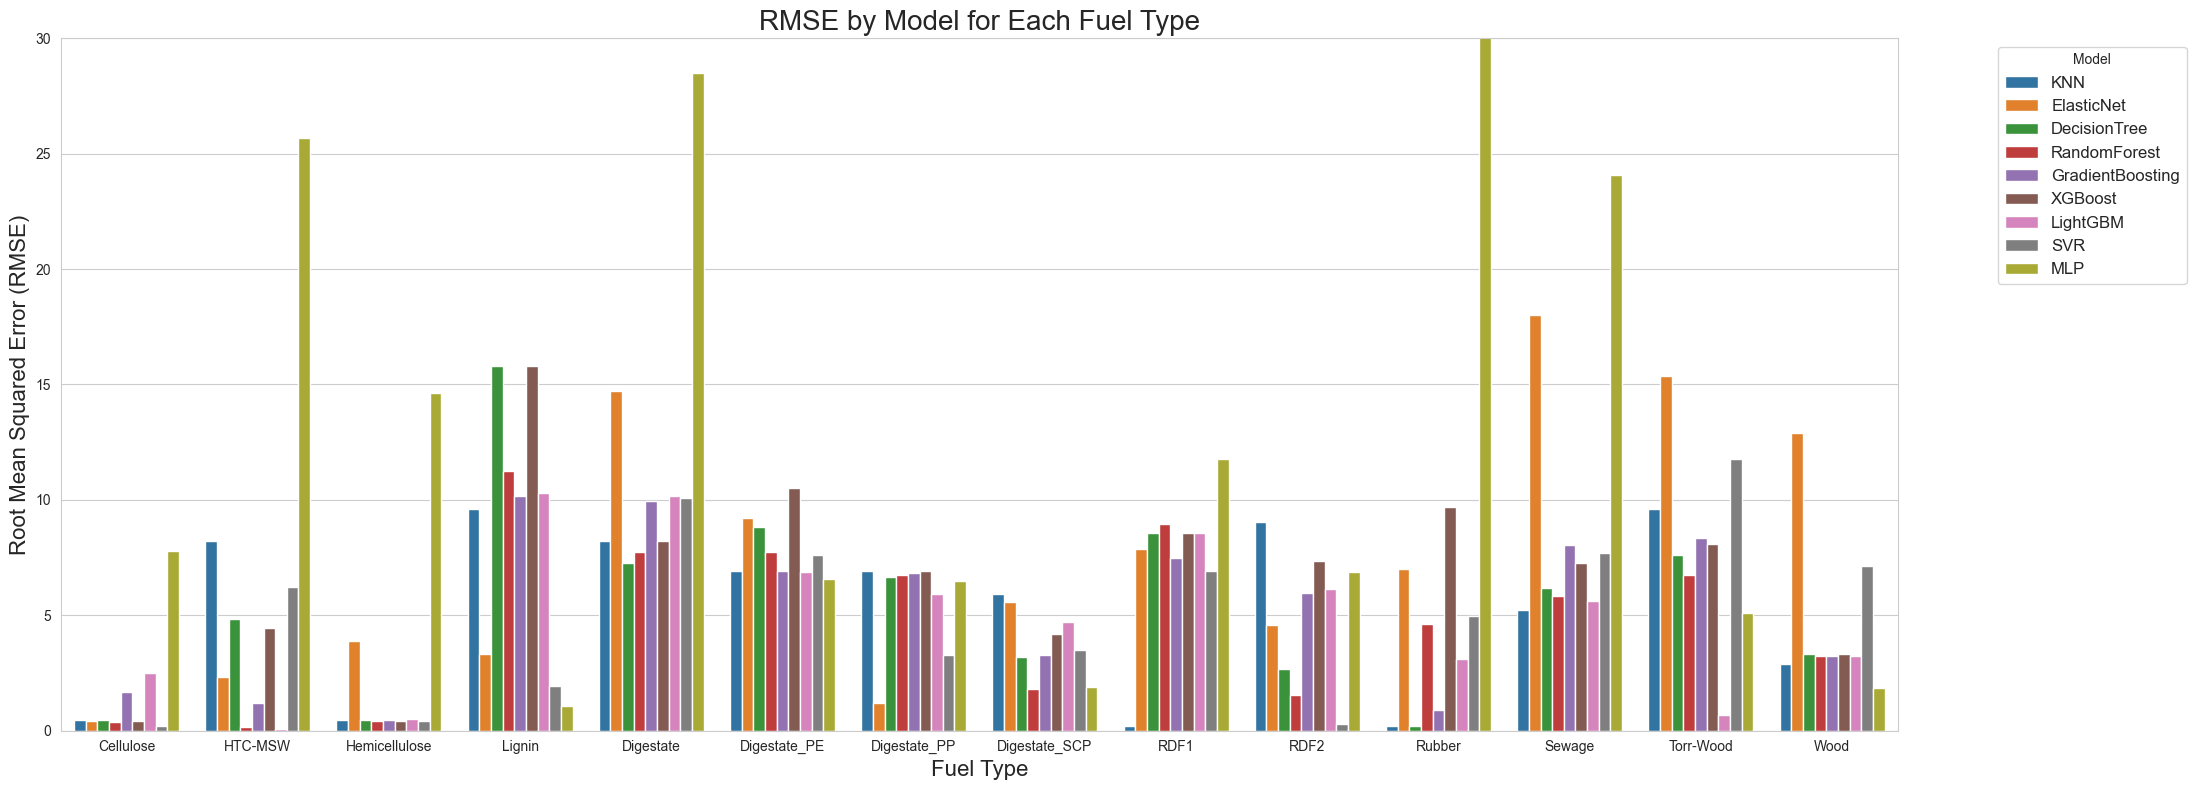

In [121]:
plt.figure(figsize=(22, 8))
sns.barplot(data=results_df, x="Fuel Type", y="RMSE", hue="Model")
plt.title("RMSE by Model for Each Fuel Type", fontsize=20)
plt.ylabel("Root Mean Squared Error (RMSE)", fontsize=16)
plt.xlabel("Fuel Type", fontsize=16)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.ylim(0,30)
plt.tight_layout()
plt.show()

In [122]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

hyperparameter_tuned_results = []
# Add to your loop:
for test_fuel in fuel_types:
    print(f"Tuning LightGBM for fuel type: {test_fuel}")

    # Train-test split
    train_data = df[df['fuel_type'] != test_fuel].drop(columns=[
        'fuel_type','fuel_category', 'ln_T', 'inv_T', 'dalpha', 'y','pressure',
        'T_kelvin', 'ln_ln_1_over_y','devol_yield', 'temperature', 'heat_rate',
        'residence_time', 'second_fuel_category', 'third_fuel_category', 'forth_fuel_category'
    ]).reset_index(drop=True)

    test_data = df[df['fuel_type'] == test_fuel].drop(columns=[
        'fuel_type','fuel_category', 'ln_T', 'inv_T', 'dalpha', 'y','pressure',
        'T_kelvin', 'ln_ln_1_over_y', 'devol_yield', 'temperature', 'heat_rate',
        'pressure','residence_time', 'second_fuel_category', 'third_fuel_category', 'forth_fuel_category'
    ]).reset_index(drop=True)

    X_train = train_data.drop(columns=['sample', 'E3_Broido_kJmol','Unnamed: 0'], errors='ignore')
    y_train = train_data['E3_Broido_kJmol']
    X_test = test_data.drop(columns=['sample', 'E3_Broido_kJmol', 'Unnamed: 0'], errors='ignore')
    y_test = test_data['E3_Broido_kJmol']

    # Refit global scaler if needed
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    # --- Hyperparameter tuning ---
    param_dist = {
        "n_estimators": [500, 1000,2000],
        "learning_rate": [0.1, 0.02, 0.05],
        "max_depth": [3, 5, 10],
        "num_leaves": [15, 31, 63],
        "min_child_samples": [5, 10, 20],
        "reg_alpha": [0.1, 0.02, 0.05],
    }

    base_model = lgb.LGBMRegressor(objective='huber', random_state=42)
    search = RandomizedSearchCV(
        base_model, param_distributions=param_dist,
        n_iter=20, cv=3, scoring='neg_mean_squared_error',
        verbose=0, n_jobs=-1, random_state=42
    )
    search.fit(X_train_scaled, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    score = best_model.score(X_test_scaled, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    for yt, yp in zip(y_test, y_pred):
        hyperparameter_tuned_results.append({
            "Fuel Type": test_fuel,
            "Model": "Tuned_LightGBM",
            "RMSE": rmse,
            "MAE": mae,
            "R-Squared": score,
            "True E3": yt,
            "Predicted E3": yp
        })


Tuning LightGBM for fuel type: Cellulose
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 964, number of used features: 23
[LightGBM] [Info] Start training from score 20.901168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

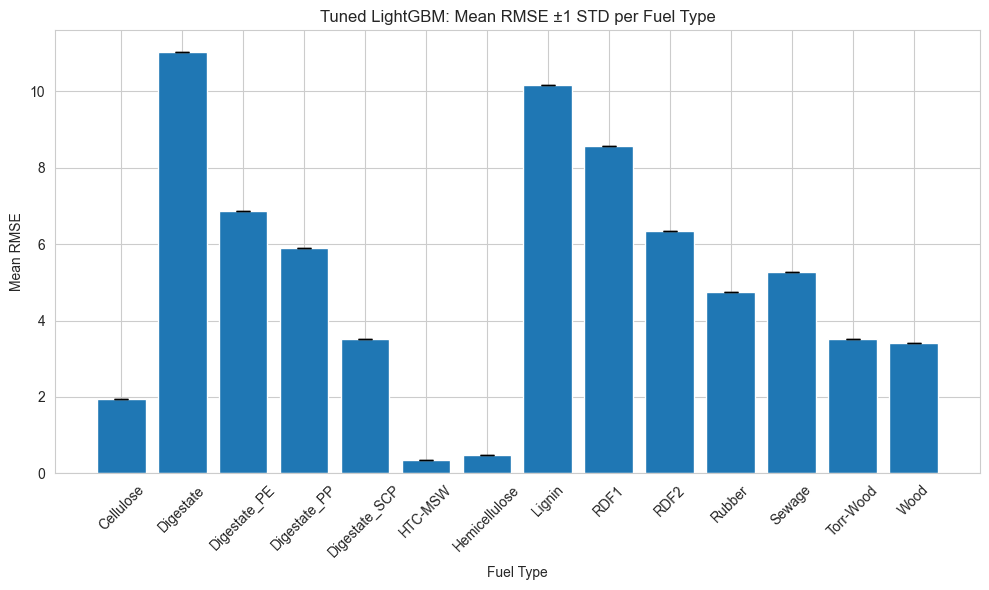

C:\Users\demir\AppData\Local\Temp\ipykernel_18240\441706510.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(rmse_groups, labels=summary['Fuel Type'])


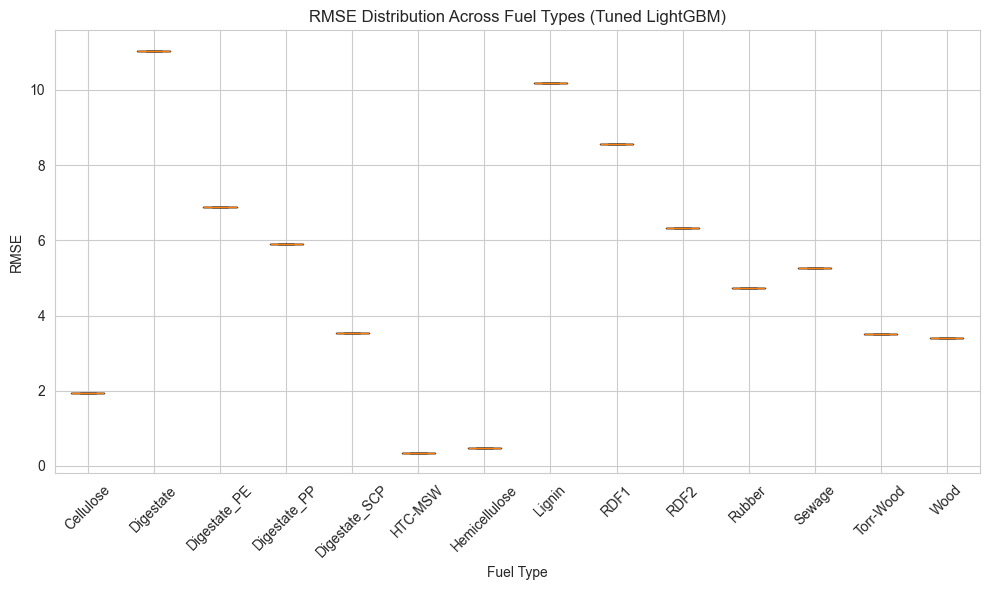

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert results to DataFrame
results_hyper_df = pd.DataFrame(hyperparameter_tuned_results)

# Summary by fuel type
summary = results_hyper_df.groupby('Fuel Type').agg(
    mean_RMSE=('RMSE', 'mean'),
    std_RMSE=('RMSE', 'std'),
    mean_MAE=('MAE', 'mean'),
    std_MAE=('MAE', 'std'),
    mean_R2=('R-Squared', 'mean'),
    std_R2=('R-Squared', 'std')
).reset_index()

# Bar plot: Mean RMSE ± 1 STD by Fuel Type
plt.figure(figsize=(10, 6))
plt.bar(summary['Fuel Type'], summary['mean_RMSE'], yerr=summary['std_RMSE'], capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Mean RMSE")
plt.xlabel("Fuel Type")
plt.title("Tuned LightGBM: Mean RMSE ±1 STD per Fuel Type")
plt.tight_layout()
plt.show()

# Boxplot: RMSE distribution per fuel type
plt.figure(figsize=(10, 6))
rmse_groups = [results_hyper_df[results_hyper_df['Fuel Type'] == ft]['RMSE'] for ft in summary['Fuel Type']]
plt.boxplot(rmse_groups, labels=summary['Fuel Type'])
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.xlabel("Fuel Type")
plt.title("RMSE Distribution Across Fuel Types (Tuned LightGBM)")
plt.tight_layout()
plt.show()


      Fuel Type           Model      RMSE       MAE    True E3  Predicted E3  \
0     Cellulose        LightGBM  2.511301  2.511301  30.584503     33.095803   
1     Cellulose        LightGBM  2.511301  2.511301  30.584503     33.095803   
2     Cellulose        LightGBM  2.511301  2.511301  30.584503     33.095803   
3     Cellulose        LightGBM  2.511301  2.511301  30.584503     33.095803   
4     Cellulose        LightGBM  2.511301  2.511301  30.584503     33.095803   
...         ...             ...       ...       ...        ...           ...   
1965       Wood  Tuned_LightGBM  3.404353  3.404353  33.475037     30.070683   
1966       Wood  Tuned_LightGBM  3.404353  3.404353  33.475037     30.070683   
1967       Wood  Tuned_LightGBM  3.404353  3.404353  33.475037     30.070683   
1968       Wood  Tuned_LightGBM  3.404353  3.404353  33.475037     30.070683   
1969       Wood  Tuned_LightGBM  3.404353  3.404353  33.475037     30.070683   

       Tuning     R-Squared  
0     Unt

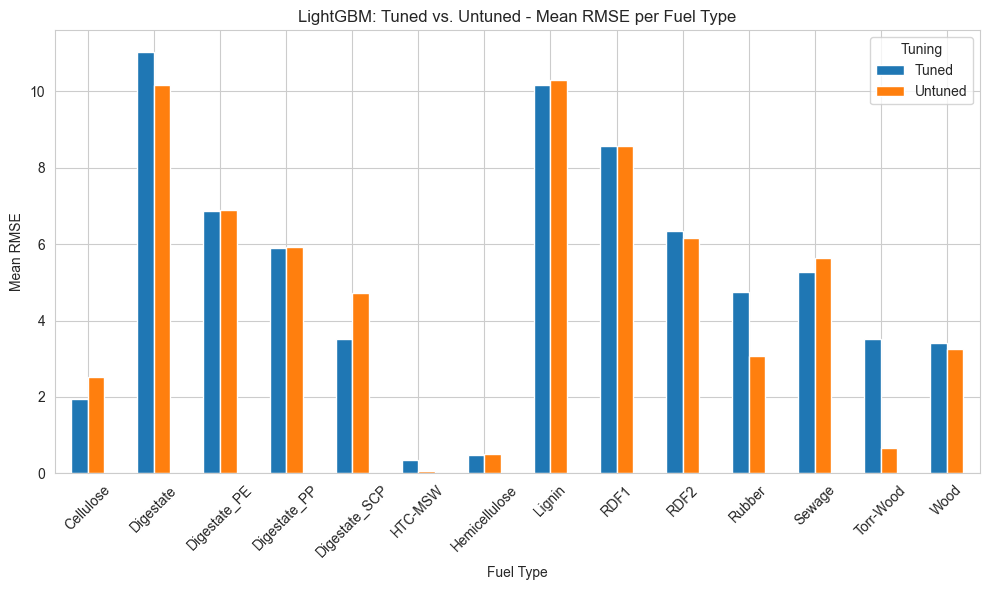

<Figure size 800x600 with 0 Axes>

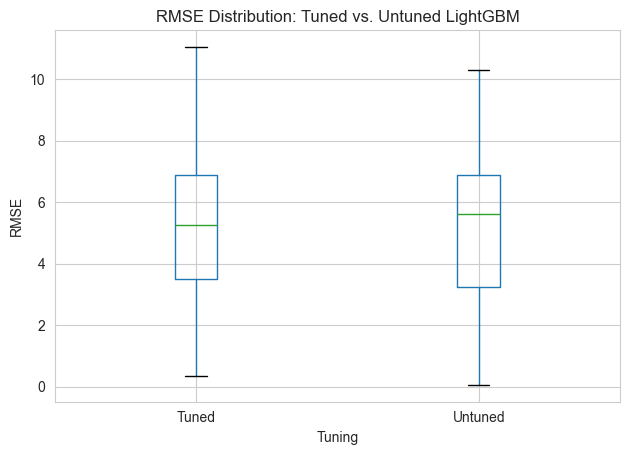

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the tuned results to DataFrame
tuned_df = pd.DataFrame(hyperparameter_tuned_results)
tuned_df["Tuning"] = "Tuned"

# Mark the untuned results
lightgbm_untuned_df = results_df[results_df["Model"] == "LightGBM"].copy()
lightgbm_untuned_df["Tuning"] = "Untuned"

# Combine for comparison
comparison_df = pd.concat([lightgbm_untuned_df, tuned_df], ignore_index=True)
print(comparison_df)
# --- 1. Bar Chart: Mean RMSE per Fuel Type (Tuned vs Untuned) ---
summary = comparison_df.groupby(['Fuel Type', 'Tuning']).agg(
    mean_RMSE=('RMSE', 'mean'),
    std_RMSE=('RMSE', 'std')
).reset_index()

# Pivot for grouped bar plot
pivoted = summary.pivot(index='Fuel Type', columns='Tuning', values='mean_RMSE')

pivoted.plot(kind='bar', figsize=(10, 6), capsize=4)
plt.ylabel("Mean RMSE")
plt.title("LightGBM: Tuned vs. Untuned - Mean RMSE per Fuel Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 2. Boxplot: RMSE Distribution for All Fuels ---
plt.figure(figsize=(8, 6))
comparison_df.boxplot(column="RMSE", by="Tuning")
plt.title("RMSE Distribution: Tuned vs. Untuned LightGBM")
plt.suptitle("")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()

# --- 3. Optional: Save combined results ---
# comparison_df.to_csv("lightgbm_comparison_results.csv", index=False)
